# Best-first Needleman-Wunsch

Concluimos na seção anterior que o Bellman-Ford entrega o mesmo resultado que o Needleman-Wunsch original, mas com uma performance consideravelmente pior. Se, porém, reavaliarmos a estrutura do grafo gerado nessa estratégia, poderemos notar que todas as arestas levam a um único nó sumidouro. Outra forma de se interpretar isso é que, pela sua construção, todas as arestas apontam para uma de três direções: $\downarrow$, $\rightarrow$ ou $\searrow$. A partir dessa análise, podemos observar que os grafos construidos para solucionar o alinhamento de sequências é **acíclico**, formando um DAG (*Directed Acyclic Graph*).

Essa conclusão é importante pois a presença de pesos negativos implica a possibilidade da existência de ciclos negativos, o que impõe preocupações e limitações severas em algoritmos  de caminhamento, porém, se o grafo não possui ciclos, obviamente, ele não possúi ciclos negativos. Considerando esse fato, podemos otimizar o algoritmo desenvolvido na seção anterior se, em vez de nos inspirarmos no Bellman-Ford, fazermos uma adaptação Heurística do Dijkstra.

Nessa seção, iremos desenvolver o **BFNW** - **B**est-**F**irst **N**eedleman-**W**unsch, uma Heurística que usa uma estratégia gulosa "*best-first*" para encontrar o alinhamento global de um par de sequências. A ideia envolve simular o caminhamento no grafo ponderado, direcionado e acíclico descrito na seção anterior, porém, o caminho de custo máximo será computado usando uma técnica de priorização similar à de Dijkstra: a cada iteração, o próximo nó a ser expandido será aquele que leva ao maior caminho imediato.

In [1]:
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.constantes as constantes
import utils.func_utils as func_utils
import utils.maxheap as maxheap
import nw_original.nw_original as nw_original

In [2]:
class NodoAuxiliar:

    def __init__(self, i, j, valor_acumulado, direcao):
        self.i = i
        self.j = j
        self.valor_acumulado = valor_acumulado
        self.direcao = direcao

    def __str__(self):
        return "i: " + str(self.i) + ",j: " + str(self.j) + ", va: " + str(self.valor_acumulado) + ", dir: " + str(self.direcao)

    def __repr__(self):
        return str(self)

    def __lt__(self, other):
        return self.valor_acumulado < other.valor_acumulado

    def __le__(self, other):
        return self.valor_acumulado <= other.valor_acumulado

    def __gt__(self, other):
        return self.valor_acumulado > other.valor_acumulado

    def __ge__(self, other):
        return self.valor_acumulado >= other.valor_acumulado

In [3]:
def bfnw(
    v,
    w,
    matriz_pontuacao=constantes.matriz_pontuacao_blosum62,
    dicionario_indice_alfabeto=constantes.dicionario_indice_alfabeto_all_amino,
    penalidade_indel=constantes.PENALIDADE_INDEL):

    len_v = len(v)
    len_w = len(w)

    fonte = NodoAuxiliar(0, 0, 0, -np.inf)
    heap = maxheap.MaxHeap()
    heap.insert(fonte)

    matriz_similaridade = np.ones((len_v+1, len_w+1)) * (-np.inf)
    # Nesse caso, a matriz de similaridade tem propriedades MUITO importantes usadas pelo algoritmo:
    # Além de guardar os valores acumulados para cada Nó, todas as suas posições são inicializadas
    # em -inf, logo, se algum valor for diferente de -inf, isso significa que aquele nó já foi visitado/expandido.

    # A matriz que armazena as regras de posicionamento ou direcionamento do caminho
    # 0 = "north", 1 = "west", 2 = "northwest" e -inf = "Não computado"
    matriz_posicionamento = np.ones((len_v+1, len_w+1)) * (-np.inf)

    while not heap.isEmpty():
        # Buscando o melhor vértice ou nó ainda aberto "k" (nesse algorítmo, o com maior valor)
        k = heap.extractMax()

        # Fechando esse nó, apenas se o valor dele for maior que o que já foi computado:
        if k.valor_acumulado > matriz_similaridade[k.i, k.j]:
            matriz_similaridade[k.i, k.j] = k.valor_acumulado
            matriz_posicionamento[k.i, k.j] = k.direcao
        else:
            continue

        # Condição de parada. Verificando se chegou no vértice sumidouro!!!
        if k.i == len_v and k.j == len_w:
            break

        # Computando os próximos vértices

        # Casando elemento de v com inserção em w, vai pra baixo:
        if k.i < len_v:
            no_baixo = NodoAuxiliar(k.i+1, k.j, k.valor_acumulado - penalidade_indel, 0)
            heap.insert(no_baixo)

        # Casando elemento de w com inserção em v, vai pra direita:
        if k.j < len_w:
            no_direita = NodoAuxiliar(k.i, k.j+1, k.valor_acumulado - penalidade_indel, 1)
            heap.insert(no_direita)

        # Casamento, vai para "baixo-direita" (Se vai dar match mesmo ('T' == 'T') ou deu
        # mismatch ('G' != 'T'), não importa. Isso está mapeado na matriz de pontuação)
        if k.i < len_v and k.j < len_w:
            valor_match = matriz_pontuacao[dicionario_indice_alfabeto[v[k.i]], dicionario_indice_alfabeto[w[k.j]]]
            no_baixo_direita = NodoAuxiliar(k.i+1, k.j+1, k.valor_acumulado + valor_match, 2)
            heap.insert(no_baixo_direita)
            
        """
        Observação IMPORTANTE: Assim como no nw original, a ordem das inserções acima INFLUENCIAM
        no caminhamento final, no sentido de que alguns caminhos terão prioridade quando houver
        algum empate nos valores.
        """

    return matriz_posicionamento, matriz_similaridade

In [4]:
def executar_alinhamento_e_printar_valores(v, w):
    
    print("Alinhamento global par-a-par com o BFNW das strings a seguir:")
    print(v)
    print(w)
    print("----------------------")
    
    matriz_posicionamento, matriz_similaridade = bfnw(v, w)

    print("\nMatriz de posicionamento (equivale ao mapa de posicionamento):")
    print(matriz_posicionamento)

    print("\nMapa de Posicionamento")
    print(func_utils.computar_mapa_posicionamento(matriz_posicionamento))
    print("----------------------")

    print("Matriz de similaridade:")
    print(matriz_similaridade)

    print("\nMaior Pontuação: ", matriz_similaridade[len(v), len(w)])

    alin_v, alin_w = func_utils.computar_alinhamento(v, w, matriz_posicionamento)
    print("\nAlinhamento")
    print(alin_v)
    print(alin_w)

In [5]:
executar_alinhamento_e_printar_valores(v="DRQT", w="DRQT")

Alinhamento global par-a-par com o BFNW das strings a seguir:
DRQT
DRQT
----------------------

Matriz de posicionamento (equivale ao mapa de posicionamento):
[[-inf -inf -inf -inf -inf]
 [-inf   2. -inf -inf -inf]
 [-inf -inf   2. -inf -inf]
 [-inf -inf -inf   2. -inf]
 [-inf -inf -inf -inf   2.]]

Mapa de Posicionamento
          
  \       
    \     
      \   
        \ 

----------------------
Matriz de similaridade:
[[  0. -inf -inf -inf -inf]
 [-inf   6. -inf -inf -inf]
 [-inf -inf  11. -inf -inf]
 [-inf -inf -inf  16. -inf]
 [-inf -inf -inf -inf  21.]]

Maior Pontuação:  21.0

Alinhamento
DRQT
DRQT


In [6]:
executar_alinhamento_e_printar_valores(v="DRET", w="DRQT")

Alinhamento global par-a-par com o BFNW das strings a seguir:
DRET
DRQT
----------------------

Matriz de posicionamento (equivale ao mapa de posicionamento):
[[-inf -inf -inf -inf -inf]
 [-inf   2. -inf -inf -inf]
 [-inf -inf   2. -inf -inf]
 [-inf -inf -inf   2. -inf]
 [-inf -inf -inf -inf   2.]]

Mapa de Posicionamento
          
  \       
    \     
      \   
        \ 

----------------------
Matriz de similaridade:
[[  0. -inf -inf -inf -inf]
 [-inf   6. -inf -inf -inf]
 [-inf -inf  11. -inf -inf]
 [-inf -inf -inf  13. -inf]
 [-inf -inf -inf -inf  18.]]

Maior Pontuação:  18.0

Alinhamento
DRET
DRQT


In [7]:
executar_alinhamento_e_printar_valores(v="DRNTAQLLGTDTT", w="DRQTAQAAGTTTIT")

Alinhamento global par-a-par com o BFNW das strings a seguir:
DRNTAQLLGTDTT
DRQTAQAAGTTTIT
----------------------

Matriz de posicionamento (equivale ao mapa de posicionamento):
[[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf]
 [-inf   2. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf]
 [-inf -inf   2. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf]
 [-inf -inf   0.   2. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf]
 [-inf -inf -inf -inf   2. -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf]
 [-inf -inf -inf -inf -inf   2. -inf -inf -inf -inf -inf -inf -inf -inf
  -inf]
 [-inf -inf -inf -inf -inf -inf   2.   1. -inf -inf -inf -inf -inf -inf
  -inf]
 [-inf -inf -inf -inf -inf -inf   0.   1.   1.   1. -inf -inf -inf -inf
  -inf]
 [-inf -inf -inf -inf -inf -inf   0. -inf   0. -inf -inf -inf -inf -inf
  -inf]
 [-inf -inf -inf -inf -inf -inf -inf   2.   1.   2. -inf -inf -inf -inf
  -inf]
 [-inf -inf -inf -inf 

In [8]:
executar_alinhamento_e_printar_valores(v="DRQTAKAAGTD", w="ERQLAKAAAGTD")

Alinhamento global par-a-par com o BFNW das strings a seguir:
DRQTAKAAGTD
ERQLAKAAAGTD
----------------------

Matriz de posicionamento (equivale ao mapa de posicionamento):
[[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 [-inf   2. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf   2. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf   2.   1.   1. -inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf   0.   1.   2. -inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf   0.   1.   2. -inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf   0. -inf -inf   2. -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf   2. -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf   2.   1. -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf   0. -inf   2. -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf   2. -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf   2.]]

Mapa de 

Alguns detalhes de implementação merecem destaque nesse algoritmo: Primeiramente, o uso da estrutura de dados *max-heap* permite que o algoritmo priorize caminhos mais promissores (que equivalem a alinhamentos com um ganho maior) ao sempre processar primeiro o nó com o maior ganho acumulado na *heap* (por isso o nome *best-first*). Vale ressaltar, porém, que esse caminho/alinhamento é computado de forma gulosa (*greedy*) e não necessariamente é o melhor caminho possível. O fato dessa *heap* ter complexidade assintótica de inserção e extração $O(log(k))$ é um fator de otimização extremamente importante para essa implementação. Por fim, outra decisão importante para essa estratégia é que o algoritmo está configurado para imediatamente parar assim que o nó sumidouro (na última posição, $(i, j)$) for alcançado pela primeira vez.  

Para entendermos a sua ordem de complexidade, podemos analisar seu fluxo de execução. Para simplificar, seja $k = |v| \times |w|$. A criação do grafo em si é proporcional à multiplicação dos tamanhos das sequências ($O(k)$). Sua iteração principal é realizada enquanto a *heap* não estiver vazia e o número de elementos a serem inseridos nela também é proporcional ao tamanho multiplicado das *strings*, logo, o número de iterações é da ordem $O(k)$. As funções de extração (feita uma vez) e inserção (feita 3 vezes) na *heap* são ambas $O(log_2(k))$. O restante das operações são constantes e atômicas, com complexidade $O(1)$, logo, a complexidade total do algoritmo é:

$$
O(k) + O(k \times (O(log(k) + 3 \times O(log(k)) + O(1)) ) = \\
O(k \times log(k)) = \\
O(|v| \times |w| \times log(|v| \times |w|))
$$

A partir desse cálculo, verificamos que a complexidade assintótica do BFNW é maior que a do NW original e, a princípio, poderíamos argumentar que não há nenhum tipo de ganho ao usar essa heurística. Entretanto, nos testes estatísticos que executaremos a seguir, encontraremos um resultado positivamente contraditório.

## Análise estatística e comparativa dos métodos acima

Para fazer uma análise mais profunda e que permita uma comparação real entre o Needleman-Wunsch original e o BFNW implementado acima, usaremos uma metodologia estatística que envolve os seguintes passos:

* 1) Defina um tamanho fixo para as strings de teste. Nesse trabalho, definiremos como 100.  

* 2) Gere uma string aleatória de tamanho 100, dado um dicionário específico. Nesse caso, usaremos o dicionário dos 20 aminoácidos disponíveis.  

* 3) A partir da string original gerada em 2), aplique uma mutação de tal forma que k% da string original fique mutada.  

* 4) Usando a string original gerada em 2) e a string mutada em 3), compute o alinhamento dessas sequências usando o Needleman-Wunsch original, armazenando a quantidade de células geradas na tabela de programação dinâmica, o tempo levado para executar o algoritmo, o valor ótimo do alinhamento (valor na posição [última linha, última coluna] da matriz de similaridade) e a porcentagem de identidade.   

* 5) Ainda usando essas strings, compute o alinhamento com o algoritmo BFNW, armazenando a quantidade de nós expandidos, o tempo levado para executar essa Heurística, o melhor valor do alinhamento (valor do nó (última linha, última coluna) da matriz de similaridade equivalente) e a porcentagem de identidade.  

* 6) Repita os passos 3)-5) variando o grau de mutação de 0 (nenhuma mutação) a 100 (totalmente mutado), armazenando os valores de células calculadas/nós expandidos, tempo levado e valor ótimo obtido em cada algoritmo para cada valor de mutação.  

* 7) Para evitar vieses e gerar uma análise estatística mais confiável, execute os passos 2)-6) 1000 vezes e tire as médias de todos os resultados.  

In [9]:
# 1)
TAMANHO_SEQUENCIA = 100

In [10]:
# 2)

string_aleatoria = func_utils.gerar_string_aleatoria(TAMANHO_SEQUENCIA, constantes.dicionario_indice_alfabeto_all_amino)
print(string_aleatoria)

KKFRTMVCMTCYFLVCWANQFRMVCFYENSMHQPTNSGMTWLDANGNNVMCYHIPPCCMKLWIHMWEWTTPTYAYCANEGWGQIAITWPKCMQDPHMQCL


In [11]:
# 3)
print(string_aleatoria)
print(func_utils.mutar_string(string_aleatoria, constantes.dicionario_indice_alfabeto_all_amino, 30))

KKFRTMVCMTCYFLVCWANQFRMVCFYENSMHQPTNSGMTWLDANGNNVMCYHIPPCCMKLWIHMWEWTTPTYAYCANEGWGQIAITWPKCMQDPHMQCL
KKFKTMVCQTCYFLPCHANSFRMVCFYENSMHTPTNSGMTCLDANGANNYNRHAPPECMKMYKAWWEWTHITYRYCALRGWGQIAIEWPKCMQDPHMQCL


In [12]:
func_utils.computar_porcentagem_identidade(string_aleatoria, func_utils.mutar_string(string_aleatoria, constantes.dicionario_indice_alfabeto_all_amino, 30))

77.0

In [13]:
# 4), 5) e 6)

from datetime import datetime

def executar_algoritmos_com_mutacao(tam):
    string_original = func_utils.gerar_string_aleatoria(tam, constantes.dicionario_indice_alfabeto_all_amino)

    nw_celulas_geradas = [((tam + 1) * (tam + 1))] * 101
    nw_tempo = [0] * 101
    nw_valor_otimo = [0] * 101
    nw_identidade = [0] * 101

    bfnw_nos_expandidos = [0] * 101
    bfnw_tempo = [0] * 101
    bfnw_valor_otimo = [0] * 101
    bfnw_identidade = [0] * 101

    for k in range(0, 101):

        # Gerando a string mutada
        string_mutada = func_utils.mutar_string(string_original, constantes.dicionario_indice_alfabeto_all_amino, k)

        # Executando Needleman-Wunsch original
        tempo_inicial_nw = datetime.now()
        matriz_posicionamento_nw, matriz_similaridade_nw = nw_original.needleman_wunsch_iterativo(v=string_original, w=string_mutada)
        tempo_final_nw = datetime.now()

        # Executando BFNW
        tempo_inicial_bfnw = datetime.now()
        matriz_posicionamento_bfnw, matriz_similaridade_bfnw = bfnw(v=string_original, w=string_mutada)
        tempo_final_bfnw = datetime.now()

        ##### Colocando os valores nos vetores

        # Células geradas/Nós expandidos
        # A qtde de Células geradas é sempre fixa. Já está inicializado no vetor 'nw_celulas_geradas'
        bfnw_nos_expandidos[k] = np.count_nonzero(matriz_similaridade_bfnw != (-np.inf))

        # Tempo levado
        nw_tempo[k] = (tempo_final_nw - tempo_inicial_nw).total_seconds() * 1000
        bfnw_tempo[k] = (tempo_final_bfnw - tempo_inicial_bfnw).total_seconds() * 1000

        # Valor ótimo
        nw_valor_otimo[k] = matriz_similaridade_nw[tam, tam]
        bfnw_valor_otimo[k] = matriz_similaridade_bfnw[tam, tam]

        # Identidade
        alin_orig_nw, alin_mut_nw = func_utils.computar_alinhamento(string_original, string_mutada, matriz_posicionamento_nw)
        nw_identidade[k] = func_utils.computar_porcentagem_identidade(alin_orig_nw, alin_mut_nw)

        alin_orig_bfnw, alin_mut_bfnw = func_utils.computar_alinhamento(string_original, string_mutada, matriz_posicionamento_bfnw)
        bfnw_identidade[k] = func_utils.computar_porcentagem_identidade(alin_orig_bfnw, alin_mut_bfnw)

    return nw_celulas_geradas, nw_tempo, nw_valor_otimo, nw_identidade, bfnw_nos_expandidos, bfnw_tempo, bfnw_valor_otimo, bfnw_identidade

In [14]:
executar_algoritmos_com_mutacao(TAMANHO_SEQUENCIA)

([10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201,
  10201],
 [29.478,
  36.39,
  27.014,
  31.944,
  31.635999999999996,
  25.340999999999998,
  23.03

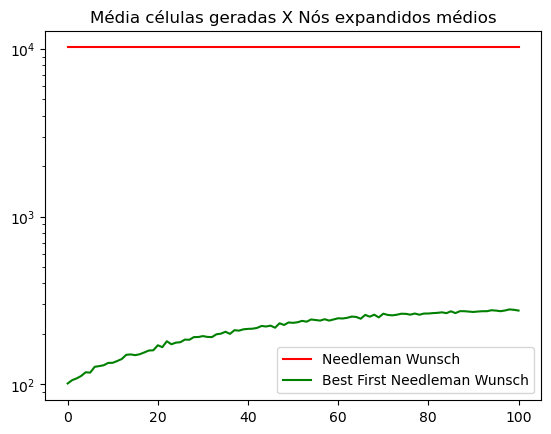

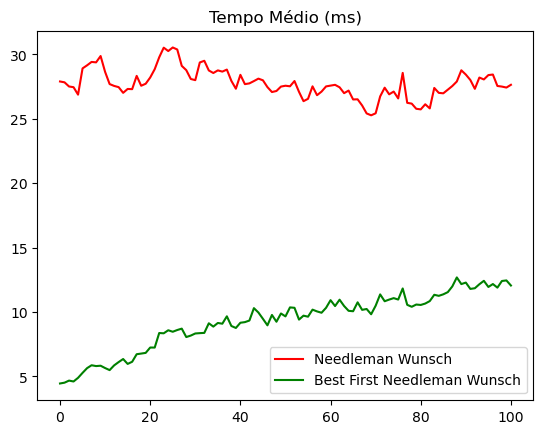

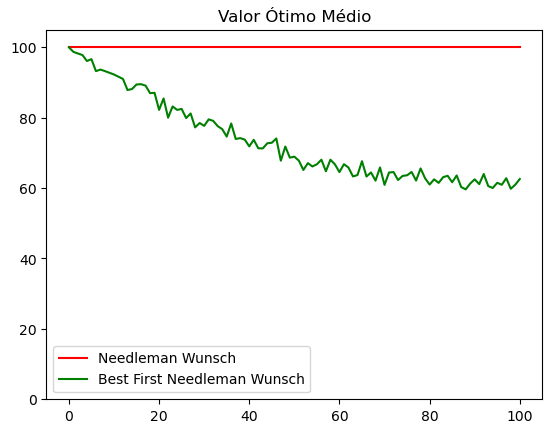

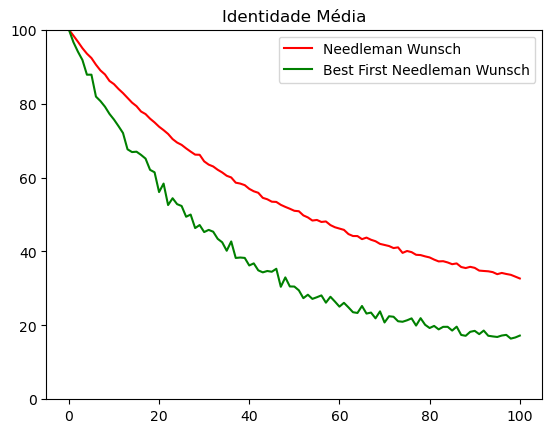

In [15]:
# 7)

import matplotlib.pyplot as plt

NUM_ITERACOES = 1000

nw_media_celulas_geradas = [((TAMANHO_SEQUENCIA + 1) * (TAMANHO_SEQUENCIA + 1))] * 101
nw_tempo_medio = np.zeros(101)
nw_porcentagem_valor_otimo_medio = np.ones(101) * 100
nw_identidade_media = np.zeros(101)

bfnw_nos_expandidos_medios = np.zeros(101)
bfnw_tempo_medio = np.zeros(101)
bfnw_porcentagem_valor_otimo_medio = np.zeros(101)
bfnw_identidade_media = np.zeros(101)

for i in range(NUM_ITERACOES):
    _, nw_tempo, nw_valor_otimo, nw_identidade, bfnw_nos_expandidos, bfnw_tempo, bfnw_valor_otimo, bfnw_identidade = executar_algoritmos_com_mutacao(TAMANHO_SEQUENCIA)

    # Somando todos os valores
    nw_tempo_medio = nw_tempo_medio + nw_tempo
    nw_identidade_media = nw_identidade_media + nw_identidade

    bfnw_nos_expandidos_medios = bfnw_nos_expandidos_medios + bfnw_nos_expandidos
    bfnw_tempo_medio = bfnw_tempo_medio + bfnw_tempo
    bfnw_porcentagem_valor_otimo_medio = bfnw_porcentagem_valor_otimo_medio + (np.array(bfnw_valor_otimo) / np.array(nw_valor_otimo)) * 100
    bfnw_identidade_media = bfnw_identidade_media + bfnw_identidade


# Tirando a média
nw_tempo_medio = nw_tempo_medio / NUM_ITERACOES
nw_identidade_media = nw_identidade_media / NUM_ITERACOES

bfnw_nos_expandidos_medios = bfnw_nos_expandidos_medios / NUM_ITERACOES
bfnw_tempo_medio = bfnw_tempo_medio / NUM_ITERACOES
bfnw_porcentagem_valor_otimo_medio = bfnw_porcentagem_valor_otimo_medio / NUM_ITERACOES
bfnw_identidade_media = bfnw_identidade_media / NUM_ITERACOES

# Plottando os valores
plt.plot(np.arange(0, 101), nw_media_celulas_geradas, color="red", label="Needleman Wunsch")
plt.plot(np.arange(0, 101), bfnw_nos_expandidos_medios, color="green", label="Best First Needleman Wunsch")
plt.legend()
plt.yscale("log")
plt.title("Média células geradas X Nós expandidos médios")
plt.show()

plt.plot(np.arange(0, 101), nw_tempo_medio, color="red", label="Needleman Wunsch")
plt.plot(np.arange(0, 101), bfnw_tempo_medio, color="green", label="Best First Needleman Wunsch")
plt.legend()
plt.title("Tempo Médio (ms)")
plt.show()

plt.plot(np.arange(0, 101), nw_porcentagem_valor_otimo_medio, color="red", label="Needleman Wunsch")
plt.plot(np.arange(0, 101), bfnw_porcentagem_valor_otimo_medio, color="green", label="Best First Needleman Wunsch")
plt.legend()
plt.title("Valor Ótimo Médio")
plt.ylim(0, 105)
plt.yticks([0,20,40,60,80,100])
plt.show()

plt.plot(np.arange(0, 101), nw_identidade_media, color="red", label="Needleman Wunsch")
plt.plot(np.arange(0, 101), bfnw_identidade_media, color="green", label="Best First Needleman Wunsch")
plt.legend()
plt.title("Identidade Média")
plt.ylim(0, 100)
plt.show()

Para os parâmetros definidos (sequências de tamanho 100), a quantidade de células processadas na matriz de memoização do NW é sempre a mesma: $(100 + 1) \times (100 + 1) = 10201$. Por outro lado, para todos os graus de mutação, a quantidade de nós expandidos pelo BFNW foi várias ordens de grandeza menor que a quantidade de células computadas. Podemos concluir que o BFNW é mais eficiente no uso de memória que o NW original.  

Ao visualizar o gráfico de tempo médio levado, fica evidente que o BFNW foi mais rápido que o NW para todos os graus de mutação - a execução mais demorada do BFNW ainda levou menos da metade do tempo da mais rápido do NW. Ainda assim, é interessante analisar e comparar o formato das curvas: No NW, o tempo levado é quase constante, não sendo influenciado pelo grau de mutação, o que é um comportamento esperado, afinal, independente do grau de mutação, o tamanho da matriz de similaridade a ser processada é sempre o mesmo. Para o BFNW, porém, a mutação teve um impacto evidente no tempo: quanto maior o grau de mutação, mais tempo é necessário para processar o alinhamento.  

Esse comportamento pode ser explicado se revisitarmos a matriz de pontuação BLOSUM62 que estamos utilizando: casamentos entre elementos idênticos (*matches*) levam a um ganho positivo alto, enquanto que casamentos entre elementos diferentes (*mismatches*) resultam em penalidades negativas. Assim, ao compararmos sequências com poucas mutações, *matches* perfeitos ocorrerão com mais frequência e a pontuação acumulada constantemente aumentará, gerando um efeito dominó que leva o algoritmo a uma finalização rápida e com poucos nós expandidos. Por outro lado, em sequências com alta mutação, vários pesos negativos serão introduzidos graças a casamentos com *mismatches* e isso fará com que mais nós correspondentes a *indels* sejam expandidos e caminhos indiretos sejam percorridos/explorados, aumentando o tempo de execução.  

O objetivo principal de ambos os algoritmos é gerar o alinhamento entre as sequências, porém, um subproduto de suas execuções é o Valor Ótimo (dado numérico encontrado na posição/nó $[i, j]$ após a execução) que corresponde ao total de pontos acumulados (ou penalidades subtraídas) para o alinhamento gerado. Podemos usar o valor relativo para comparar a qualidade dos resultados: sabemos que o NW é um algoritmo ótimo, sempre entregando o melhor alinhamento possível, logo, o Valor Ótimo Médio para esse algoritmo é sempre 100%. Se usarmos o resultado gerado pelo NW como linha de base e calcularmos o Valor Ótimo encontrado pelo BFNW, concluiremos que o grau de mutação também influencia na qualidade da solução gerada, afinal, *strings* similares geram pontuações muito boas, mas ao passo que o grau de mutação aumenta, as soluções obtidas ficam piores em relação ao alinhamento ótimo. O resultado começa extremamente acurado em 100% com nenhuma mutação, mas decresce rapidamente até estabilizar por volta de 65% de otimalidade com mutação total. Esse resultado enfatiza ainda que o BFNW tem natureza heurística e seus resultados não são perfeitos.

Outra métrica de comparação interessante é a medida de identidade: dadas duas sequências já alinhadas, a identidade é a porcentagem relativa que indica o quão similares ou parecidas essas *strings* são. A computarmos essa métrica nos testes acima, podemos observar uma correlação importante: a identidade média de ambos os algoritmos é total quando não há mutação (o que faz sentido, afinal, o alinhamento de sequências idênticas é a própria sequência) mas cai rapidamente quando aumentamos o grau de mutação (o que também faz sentido, pois o alinhamento de *strings* muito diferentes será muito ruim). Ainda assim, é importante notar que as medidas de identidade para o BFNW sempre são iguais ou menores que as identidades do NW original (começam iguais, mais se separam cada vez mais à medida que o grau de mutação aumenta), o que é esperado, afinal, o BFNW não é um algoritmo ótimo.

A partir desses resultados, argumentamos que o BFNW se sai extremamente bem quando está fazendo o alinhamento de sequências que sabemos que são relativamente similares, pois, nessas condições, os resultados são acurados, são gerados com extrema rapidez e ocupam pouquíssima memória durante o processamento. Por outro lado, para sequências intencionalmente dissimilares, o BFNW ainda é rápido, continua levando pouca memória de processamento, mas a qualidade dos resultados é relativamente pior em relação ao alinhamento ótimo encontrado pelo NW tradicional. Ainda assim, nessa última situação, mesmo que o resultado do BFNW seja ruim, o alinhamento ótimo do NW também será ruim na prática (isso é corroborado pelo último gráfico acima, pois a Identidade Média resultada pelo NW para altas mutações alcança níveis tão baixos quanto 40%, o que não difere muito das piores identidades do BFNW, que alcançam 20%)

## Testes com proteinas reais

Em um teste final, desejamos comparar a performance entre esses algoritmos ao alinhar sequências reais. As *strings* que iremos usar para testes correspondem às glicoproteínas *spike* dos vírus SARS-CoV e SARS-CoV-2.

In [16]:
spike_sars_cov = "MVSAIVLYVLLAAAAHSAFASDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFDNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDTWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCSFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQAAPHGVVFLHVTYVPSQERNFTTAPAICHEGKAYFPREGVFVFNGTSWFITQRNFFSPQIITTDNTFVSGNCDVVIGIINNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKPSGRLVPRGSPGSGYIPEAPRDGQAYVRKDGEWVLLSTFLGHHHHHH"
spike_sars_cov_2 = "MGILPSPGMPALLSLVSLLSVLLMGCVAETGMFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSRASSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDPPEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELD"

In [17]:
# Executando Needleman-Wunsch original
tempo_inicial_nw = datetime.now()
matriz_posicionamento_nw, matriz_similaridade_nw = nw_original.needleman_wunsch_iterativo(v=spike_sars_cov, w=spike_sars_cov_2)
tempo_final_nw = datetime.now()

# Executando BFNW
tempo_inicial_bfnw = datetime.now()
matriz_posicionamento_bfnw, matriz_similaridade_bfnw = bfnw(v=spike_sars_cov, w=spike_sars_cov_2)
tempo_final_bfnw = datetime.now()

In [18]:
print("----- Média células geradas X Nós expandidos médios -----")
print("NW:", matriz_similaridade_nw.shape[0] * matriz_similaridade_nw.shape[1], "células geradas")
print("BFNW:", np.count_nonzero(matriz_similaridade_bfnw != (-np.inf)), "nós expandidos")

print("----- Tempo levado -----")
print("NW:", (tempo_final_nw - tempo_inicial_nw).total_seconds() * 1000, "ms")
print("BFNW:", (tempo_final_bfnw - tempo_inicial_bfnw).total_seconds() * 1000, "ms")

print("----- Valor ótimo-----")
print("NW:", matriz_similaridade_nw[len(spike_sars_cov), len(spike_sars_cov_2)])
print("BFNW:", matriz_similaridade_bfnw[len(spike_sars_cov), len(spike_sars_cov_2)])

print("----- Alinhamento e Identidade -----")
alin_v_nw, alin_w_nw = func_utils.computar_alinhamento(spike_sars_cov, spike_sars_cov_2, matriz_posicionamento_nw)
alin_v_bfnw, alin_w_bfnw = func_utils.computar_alinhamento(spike_sars_cov, spike_sars_cov_2, matriz_posicionamento_bfnw)

print("NW:", func_utils.computar_porcentagem_identidade(alin_v_nw, alin_w_nw))
print(alin_v_nw[:100])
print(alin_w_nw[:100])
print("\nBFNW:", func_utils.computar_porcentagem_identidade(alin_v_bfnw, alin_w_bfnw))
print(alin_v_bfnw[:100])
print(alin_w_bfnw[:100])

----- Média células geradas X Nós expandidos médios -----
NW: 1470144 células geradas
BFNW: 3683 nós expandidos
----- Tempo levado -----
NW: 11848.431 ms
BFNW: 502.239 ms
----- Valor ótimo-----
NW: 4898.0
BFNW: 1638.0
----- Alinhamento e Identidade -----
NW: 63.24167872648335
M-V--S----A---IV-LY--VLL-AAAAHS---AF-------ASDLDRC---TTFDD-VQA-PN--YTQHTS-SMRGVYYPDEIFRSDT-LYL-TQDLF
MGILPSPGMPALLSLVSL-LSVLLMGCVAETGMFVFLVLLPLVSS---QCVNLTT---RTQ-LP-PAYT-N-SFT-RGVYYPDKVFRS-SVLH-STQDLF

BFNW: 12.047511312217194
M-V--S-AI--VLY-VLLA--A---A----AHSA-FASDLDR---CTTFDDVQAP--NYTQ--H-TS-SMRGVYYP----DEIFRSDT--LYLTQDLFLP
MGILPSPGMPALL-SLV-SLLSVLL-MGCVAETGMF---V--FLV---L--L--PLVS-SQCVNLTTRT-Q-L--PPAYTNS-F-T--RGVY-----Y-P


É evidente que o BFNW foi bem mais rápido e necessitou de menos memória para processar as *strings*, porém, a qualidade do alinhamento foi muito ruim: Enquanto o NW alcançou uma identidade razoável de 63%, o BFNW não conseguiu acertar nem 20% dos elementos nas sequências alinhadas.

https://sci-hub.se/10.1016/j.cell.2020.02.058  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8427004/  
https://files.rcsb.org/view/7ZH1.cif  
https://files.rcsb.org/view/7BNM.cif  